<a href="https://colab.research.google.com/github/ck1972/Python-Geospatial_Model1/blob/main/5c_FloodMapping_UNET_GradCAM_XAI_Model1_12_11_2024_Final_GH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Flood Mapping: Using Grad-CAM for Enhanced Explainability**
## **Introduction**
Flooding is a destructive natural hazard. While traditional Earth observation methods have been used for flood mapping, they face limitations in speed, accuracy, and scalability.

Deep learning offers a more efficient approach but still struggles with generalization, prediction uncertainty, and the need for explainability.

This tutorial uses a U-Net model for segmentation and gradient class-activation mapping (Grad-CAM) for enhanced interpretability. A Kaggle flood dataset is used to demonstrate the approach.

### Flood dataset
The dataset contains 290 images of flood-affected areas along with corresponding mask images.
Data source: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation

## **Organization of the Tutorial**
The video tutorial is organized as follows:
1. Environment setup and library installation
2. Preprocessing the datasets
3. Deep learning using a U-Net model
4. Gradient-weighted class activation mapping (Grad-CAM)

## **Environment Setup and Library Installation**
### Installing and importing required libraries
We need to set up the environment. First, we will mount Google Drive to access the dataset.

In [ ]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Then, we will the import necessary Python libraries and modules for data handling, image processing, and visualization.
1. os: For handling file and directory operations.
2. glob: For pattern matching and retrieving file paths.
3. numpy: For efficient numerical computations.
4. Pillow (PIL): For image processing tasks.
5. matplotlib: For data visualization and plotting.
6. random: For random operations (e.g., selecting random samples for display).

In [ ]:
# Import necessary libraries
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

### Setting up the working directory
Next, we set the working directory to where the flood dataset is stored on Google Drive.

In [ ]:
# Set the working directory to the dataset folder
os.chdir('/content/drive/MyDrive/Flood_data')

## **Preprocessing**
Next, define a function to load and preprocess images and masks for the U-Net model.

We will use the data preprocessing function to prepare images and masks for the U-Net model by loading, resizing, normalizing, and formatting them. We will convert the images to RGB and masks to grayscale, resizes them to 512x512 pixels, and normalizes pixel values to a range of [0, 1].

In [ ]:
# Function to load and preprocess images and masks
def load_and_preprocess_images(image_paths, image_size=(512, 512), is_mask=False):
    images_array = []
    for img_path in image_paths:
        img = Image.open(img_path)

        # Ensure consistent image modes
        if is_mask:
            img = img.convert('L')  # Grayscale for masks
        else:
            img = img.convert('RGB')  # RGB for images

        # Resize images
        img = img.resize(image_size)

        # Convert to numpy array
        img_array = np.array(img)

        # Normalize images
        if not is_mask:
            img_array = img_array / 255.0  # Normalize images to [0, 1]
        else:
            # Convert masks to binary
            img_array = img_array / 255.0
            img_array = (img_array > 0.5).astype(np.float32)
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

        images_array.append(img_array)

    images_array = np.array(images_array)
    return images_array

Next, we sort the lists of images and masks. To maintain alignment between the images and corresponding masks, the file paths are retrieved using the glob library and sorted consistently. This ensures that each input image matches its corresponding mask correctly.

In [ ]:
# Get sorted lists of image and mask file paths
train_image_paths = sorted(glob.glob('train/Image/*.jpg'))
train_mask_paths = sorted(glob.glob('train/Mask/*.png'))
test_image_paths = sorted(glob.glob('test/Image/*.jpg'))
test_mask_paths = sorted(glob.glob('test/Mask/*.png'))

# Load and preprocess images and masks
train_x = load_and_preprocess_images(train_image_paths, image_size=(512, 512), is_mask=False)
train_y = load_and_preprocess_images(train_mask_paths, image_size=(512, 512), is_mask=True)
test_x = load_and_preprocess_images(test_image_paths, image_size=(512, 512), is_mask=False)
test_y = load_and_preprocess_images(test_mask_paths, image_size=(512, 512), is_mask=True)

# Print dataset shapes
print(f"Training images shape: {train_x.shape}")
print(f"Training masks shape: {train_y.shape}")
print(f"Testing images shape: {test_x.shape}")
print(f"Testing masks shape: {test_y.shape}")

Training images shape: (203, 512, 512, 3)
Training masks shape: (203, 512, 512, 1)
Testing images shape: (87, 512, 512, 3)
Testing masks shape: (87, 512, 512, 1)


### Display a sample image and mask
The next step is to visualize a sample image and its corresponding mask from the training dataset using matplotlib.

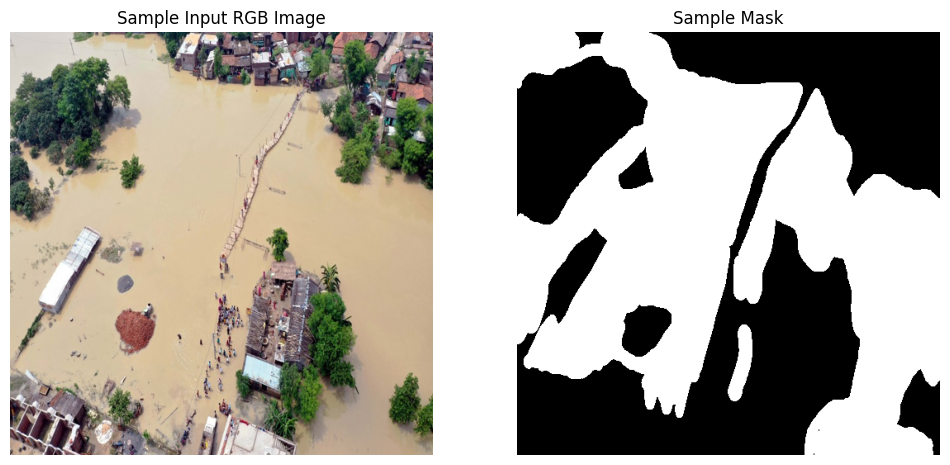

In [ ]:
# Visualize a sample image and mask
index = 10  # Adjust as needed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(train_x[index])
plt.title('Sample Input RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_y[index].squeeze(), cmap='gray')
plt.title('Sample Mask')
plt.axis('off')

plt.show()

## Deep Learning using U-Net
### What is U-Net?
U-Net is a convolutional neural network (CNN) architecture designed for image segmentation tasks. It was originally developed for biomedical image segmentation (Ronneberger et al., 2015).However, it has since found wide applications in various computer vision problems. The U-Net architecture consists of two main parts.

1. Contracting path (Encoder)
* A series of convolutional and max pooling layers that progressively reduce the spatial dimensions while increasing the number of feature channels.
* Captures and encodes contextual information from the input image.

2. Expanding path (Decoder)
* A series of upsampling and convolutional layers that gradually increase the spatial dimensions back to the original image size.
* Enables precise localization using the high-resolution features from the contracting path.
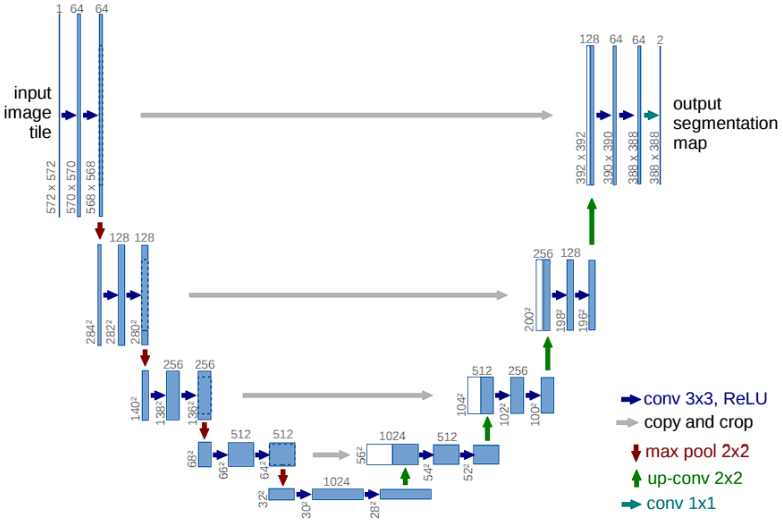

Source: Ronneberger et al., 2015

## **Set-up a U-Net Model**
We set up a U-Net model using TensorFlow and Keras for image segmentation, incorporating layers like Conv2D, Dropout, and MaxPooling2D, along with callbacks like EarlyStopping and ModelCheckpoint.

The model architecture consists of an encoder for feature extraction and a decoder for upsampling, with skip connections to retain spatial details.

The output layer uses a Conv2D layer with a sigmoid activation to produce a single-channel binary segmentation mask, while a custom Intersection over Union (IoU) metric evaluates the model's performance.

In [ ]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the IoU metric
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

# Define the UNET model
def unet_model(input_size=(512, 512, 3)):
    x_in = Input(shape=input_size)

    # Encoder
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
    x1 = Dropout(0.1)(x1)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = MaxPooling2D((2, 2))(x1)

    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = Dropout(0.1)(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = MaxPooling2D((2, 2))(x2)

    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = Dropout(0.2)(x3)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = MaxPooling2D((2, 2))(x3)

    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = Dropout(0.2)(x4)
    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(x4)

    # Decoder
    u1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x4)
    u1 = Concatenate()([u1, x3])
    u1 = Dropout(0.2)(u1)
    u1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = Concatenate()([u2, x2])
    u2 = Dropout(0.2)(u2)
    u2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = Concatenate()([u3, x1])
    u3 = Dropout(0.1)(u3)
    u3 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u3)

    model = Model(inputs=x_in, outputs=outputs)
    return model

Next, the U-Net model is instantiated with an input size of 512x512 (RGB), compiled using the Adam optimizer and binary cross-entropy loss for binary segmentation.

Accuracy and a custom IoU metric are used to evaluate performance.

The model architecture is then displayed using model.summary() to show the layers and parameters.

In [ ]:
# Instantiate the model
model = unet_model(input_size=(512, 512, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

# Display the model's architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 128)  │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 256)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        295,040 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 1,946,881 (7.43 MB)

 Trainable params: 1,946,881 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

### Setup callbacks
Next, we configure three callbacks to optimize the U-Net training:

EarlyStopping halts training if no improvement is seen after 10 epochs, restoring the best weights;

ReduceLROnPlateau lowers the learning rate by 0.1 when performance stagnates for 5 epochs; and

ModelCheckpoint saves the best model weights to a file, ensuring only the best-performing version is retained.

These callbacks help prevent overfitting and enhance training efficiency.


In [ ]:
# Setup callbacks
early_stopper = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1)
checkpoint = ModelCheckpoint('unet_best_model.keras', verbose=1, save_best_only=True)

### Data augmentation
Next, we apply data augmentation using TensorFlow's ImageDataGenerator to artificially expand the training dataset with random transformations like rotation, shifting, and flipping.

In [ ]:
# Optional: Data augmentation using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Create ImageDataGenerators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the flow methods
seed = 1
batch_size = 10

image_generator = image_datagen.flow(train_x, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(train_y, batch_size=batch_size, seed=seed)

# Define the combined generator using next()
def combined_generator(image_gen, mask_gen):
    while True:
        X = next(image_gen)
        Y = next(mask_gen)
        yield X, Y

## **Train and Fit the Model**
Next, train the model is using the fit method with the augmented data.

Validation is done on a separate test set, running up to 100 epochs, with early stopping, learning rate adjustments, and checkpoint saving managed by callbacks.

The training progress, including metrics like loss and accuracy, is stored in the history variable.

In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(train_x) // batch_size

# Train the model
history = model.fit(combined_generator(image_generator, mask_generator),
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(test_x, test_y),
                    epochs=100,
                    callbacks=[early_stopper, reduce_lr, checkpoint])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6058 - iou_metric: 0.0015 - loss: 0.7051
Epoch 1: val_loss improved from inf to 0.63582, saving model to unet_best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 234s 9s/step - accuracy: 0.6048 - iou_metric: 0.0017 - loss: 0.7045 - val_accuracy: 0.7696 - val_iou_metric: 0.5027 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.6893 - iou_metric: 0.2759 - loss: 0.6043
Epoch 2: val_loss improved from 0.63582 to 0.48259, saving model to unet_best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6905 - iou_metric: 0.2815 - loss: 0.6033 - val_accuracy: 0.7749 - val_iou_metric: 0.6145 - val_loss: 0.4826 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.7586 - iou_metric: 0.5592 - loss: 0.5125
Epoch 3: val_loss did not improve from 0.48259
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7585 - iou_metric: 0.5586 - loss

## **Evaluate the Model**
Next, we evaluate the trained model on the test dataset using the evaluate function. We will calculate the test loss, accuracy, and Intersection over Union (IoU) metric. These values are printed to give insight into how well the model performs on unseen data.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 0.8839 - iou_metric: 0.7455 - loss: 0.2874
Test Loss: 0.2884581685066223
Test Accuracy: 0.883705198764801
Test IoU: 0.748645007610321


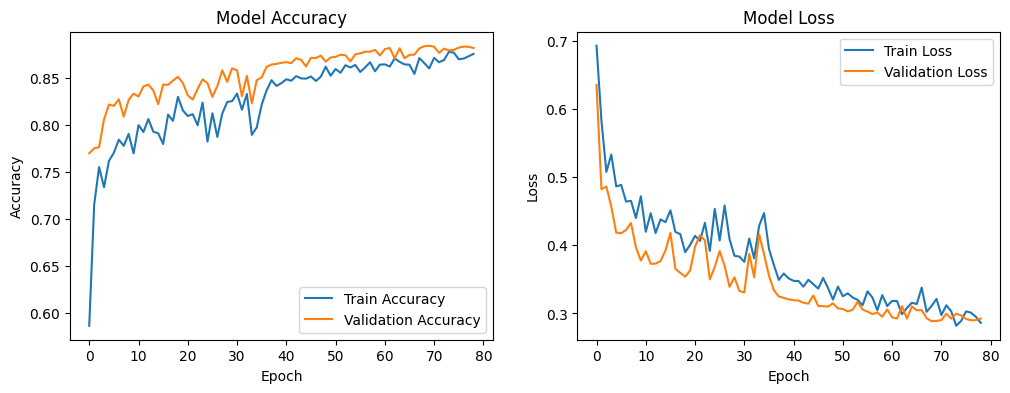

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_iou = model.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test IoU: {test_iou}")

# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

### Save the U-Net model
Next, we will save the trained U-Net model to a file named unet_model.h5 in the current working directory using the HDF5 format. The .h5 file extension indicates that the model is saved in the HDF5 binary format, which includes the model architecture, weights, and training configuration (e.g., optimizer and loss function). This allows the model to be reloaded later for further training, evaluation, or prediction without needing to retrain it from scratch.

In [ ]:
# Save the trained model
model.save('unet_model.h5')

## **Prediction**
Next, we perform predictions on the test dataset using the trained model.

In [ ]:
# Predict on test data
preds = model.predict(test_x)
preds_thresholded = (preds > 0.5).astype(np.uint8)

# Visualize some predictions
import random

num_examples = 3
indices = random.sample(range(len(test_x)), num_examples)

for idx in indices:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_x[idx])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(test_y[idx].squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_thresholded[idx].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

## **Explainable Deep Learning using Grad-CAM**
We will use Grad-CAM to interpret the U-Net model decisions.

We visualize parts of the input image that influence the U-Net model predictions.

This approach help us understand the model's focus during segmentation.

### Visualizing intermediate convnet outputs (intermediate activations)
First, we will Inspect the model to identify specific layers for the Grad-CAM visualization.

In [ ]:
# Print the layer names
for layer in model.layers:
    print(layer.name)

input_layer
conv2d
dropout
conv2d_1
max_pooling2d
conv2d_2
dropout_1
conv2d_3
max_pooling2d_1
conv2d_4
dropout_2
conv2d_5
max_pooling2d_2
conv2d_6
dropout_3
conv2d_7
conv2d_transpose
concatenate
dropout_4
conv2d_8
conv2d_transpose_1
concatenate_1
dropout_5
conv2d_9
conv2d_transpose_2
concatenate_2
dropout_6
conv2d_10
conv2d_11


### Grad-CAM with layer attribution and activation maps
Next, we will load the U-Net model.

Then, we will use the 'generate_layer_gradcam' function to extract feature maps from a specified convolutional layer and use gradients to compute importance weights for these maps.

These weights are used to create a heatmap, which is resized and color-mapped for better visualization.

Finally, the heatmap is blended with the input image to highlight the image parts the model relied on for the segmentation.


In [ ]:
# Import the necessary libraries.
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Load the U-Net model (include custom_objects if necessary)
model_unet = load_model('unet_model.h5', custom_objects={'iou_metric': iou_metric})

def generate_layer_gradcam(model, img_array, layer_name, target_class=0):
    # Get the output of the target layer
    target_layer = model.get_layer(layer_name).output
    grad_cam_model = tf.keras.models.Model(inputs=model.input, outputs=[target_layer, model.output])

    with tf.GradientTape() as tape:
        # Forward pass
        last_conv_output, model_output = grad_cam_model(img_array)
        if isinstance(model_output, list):
            model_output = model_output[0]
        # Compute the loss with respect to the target class
        class_output = tf.reduce_mean(model_output[:, :, :, target_class])

    # Compute the gradient of the class output with respect to the feature map
    grads = tape.gradient(class_output, last_conv_output)
    # Global average pooling to get importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply each channel in the feature map by "how important this channel is" with respect to the target class
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    # Resize heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    img_array_uint8 = np.uint8(255 * img_array[0] * 255)
    gradcam_result = cv2.addWeighted(img_array_uint8, 0.6, heatmap_colormap, 0.4, 0)

    return gradcam_result, heatmap_resized

Finally, we will visualize the Grad-CAM results for selected test images.

We will display the original images, Grad-CAM heatmaps, and overlays of the Grad-CAM heatmaps on the original images.


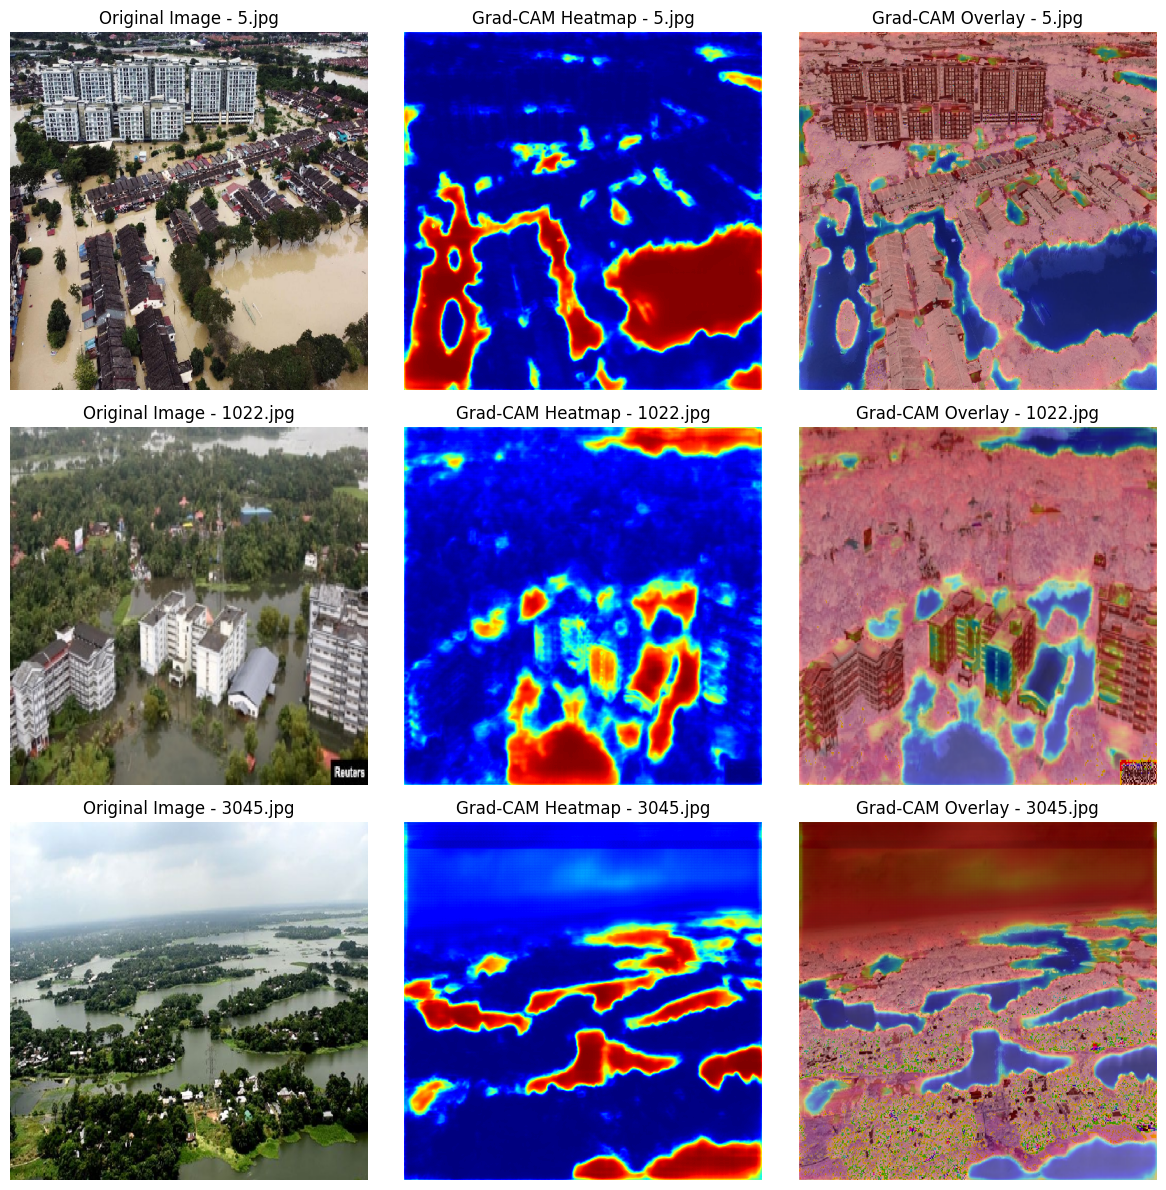

In [ ]:
# Directory containing images
img_path = '/content/drive/MyDrive/Flood_data/test/Image/'
image_filenames = ['5.jpg', '1022.jpg', '3045.jpg']
full_image_paths = [os.path.join(img_path, filename) for filename in image_filenames]

plt.figure(figsize=(12, 12))

for i, file_path in enumerate(full_image_paths):
    original_img = load_img(file_path, target_size=(512, 512))
    img_array = img_to_array(original_img)
    # Normalize the image
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    gradcam_result, heatmap_resized = generate_layer_gradcam(model_unet, img_array, "conv2d_11", 0)

    plt.subplot(len(image_filenames), 3, 3 * i + 1)
    plt.imshow(original_img)
    plt.title("Original Image - " + image_filenames[i])
    plt.axis('off')

    plt.subplot(len(image_filenames), 3, 3 * i + 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap - " + image_filenames[i])
    plt.axis('off')

    plt.subplot(len(image_filenames), 3, 3 * i + 3)
    plt.imshow(gradcam_result)
    plt.title("Grad-CAM Overlay - " + image_filenames[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Key Takeaways**
### Summary
* The U-Net model performance is relatively good as shown by the accuracy metrics.
* However, the flood maps show significant misclassifications (e.g., underestimated flood areas).
* Grad-CAM visualizations provide insights into the segmented regions influencing the model predictions.

### Next step
This tutorial demonstrates a deep learning approach to flood mapping using U-Net and Grad-CAM for enhanced explainability.

This approach helps build trust in the model’s outputs, making it a valuable tool for flood disaster management.

To learn more, please download a detailed tutorial guide at Ai.Geolabs.

The Python code is available on GitHub.